In [ ]:
%pip install torchaudio==0.9.1
%pip install thop

In [ ]:
%pip install wandb

In [ ]:
# https://wandb.ai/darya_baranovskaya/kws_hw?workspace=user-darya_baranovskaya
#https://drive.google.com/drive/folders/1gOD46jcxXMYI_hA8pabXdNN_PHuyIWfh?usp=sharing

In [1172]:
#!g1.1
from typing import Tuple, Union, List, Callable, Optional
from tqdm import tqdm
from itertools import islice
import pathlib
import dataclasses

import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
from torch import nn
from torch import distributions
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torch.nn.utils.rnn import pad_sequence

import torchaudio
from IPython import display as display_
from IPython.display import clear_output
import wandb
import torch.quantization
torch.manual_seed(3407)
torch.cuda.manual_seed(3407)

In [1069]:
#!g1.1
from model_estimation import estimate_model_complexity

In [1193]:
#!g1.1
@dataclasses.dataclass
class TaskConfig:
    keyword: str = 'sheila'  # We will use 1 key word -- 'sheila'
    batch_size: int = 128
    learning_rate: float = 3e-4
    weight_decay: float = 1e-5
    num_epochs: int = 10
    n_mels: int = 40
    cnn_out_channels: int = 8
    kernel_size: Tuple[int, int] = (5, 20)
    stride: Tuple[int, int] = (2, 8)
    hidden_size: int = 64
    gru_num_layers: int = 2
    bidirectional: bool = False
    num_classes: int = 2
    sample_rate: int = 16000
    max_window_length: int = 30
    device: torch.device = torch.device(
        'cuda:0' if torch.cuda.is_available() else 'cpu')

# Data

In [6]:
#!g1.1
# !wget http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz -O speech_commands_v0.01.tar.gz
# !mkdir speech_commands && tar -C speech_commands -xvzf speech_commands_v0.01.tar.gz 1> log

--2021-11-14 18:23:20--  http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 64.233.165.128, 2a00:1450:4010:c07::80
Connecting to download.tensorflow.org (download.tensorflow.org)|64.233.165.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1489096277 (1.4G) [application/gzip]
Saving to: ‘speech_commands_v0.01.tar.gz’

speech_commands_v0. 100%[===================>]   1.39G   154MB/s    in 9.8s    

2021-11-14 18:23:30 (144 MB/s) - ‘speech_commands_v0.01.tar.gz’ saved [1489096277/1489096277]



In [1071]:
#!g1.1
from data import SpeechCommandDataset
dataset = SpeechCommandDataset(
    path2dir='speech_commands', keywords=TaskConfig.keyword
)

In [5]:
#!g1.1
dataset.csv.sample(5)

,path,keyword,label
42233,speech_commands/six/686d030b_nohash_3.wav,six,0
28044,speech_commands/marvin/c120e80e_nohash_0.wav,marvin,0
3058,speech_commands/sheila/6414258b_nohash_2.wav,sheila,1
38155,speech_commands/down/94de6a6a_nohash_0.wav,down,0
37563,speech_commands/house/2579e514_nohash_1.wav,house,0


In [1072]:
#!g1.1
indexes = torch.randperm(len(dataset))
train_indexes = indexes[:int(len(dataset) * 0.8)]
val_indexes = indexes[int(len(dataset) * 0.8):]

train_df = dataset.csv.iloc[train_indexes].reset_index(drop=True)
val_df = dataset.csv.iloc[val_indexes].reset_index(drop=True)

In [1073]:
# Sample is a dict of utt, word and label
#!g1.1
from augmentations import AugsCreation
train_set = SpeechCommandDataset(csv=train_df, transform=AugsCreation())
val_set = SpeechCommandDataset(csv=val_df)

In [1074]:
# We should provide to WeightedRandomSampler _weight for every sample_; by default it is 1/len(target)
#!g1.1
def get_sampler(target):
    class_sample_count = np.array(
        [len(np.where(target == t)[0]) for t in np.unique(target)])   # for every class count it's number of occ.
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[t] for t in target])
    samples_weight = torch.from_numpy(samples_weight)
    samples_weigth = samples_weight.float()
    sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
    return sampler

In [1075]:
#!g1.1
train_sampler = get_sampler(train_set.csv['label'].values)
val_sampler = get_sampler(val_set.csv['label'].values)

In [1076]:
#!g1.1
class Collator:
    
    def __call__(self, data):
        wavs = []
        labels = []    

        for el in data:
            wavs.append(el['wav'])
            labels.append(el['label'])

        # torch.nn.utils.rnn.pad_sequence takes list(Tensors) and returns padded (with 0.0) Tensor
        wavs = pad_sequence(wavs, batch_first=True)    
        labels = torch.Tensor(labels).long()
        return wavs, labels

In [1079]:
# Here we are obliged to use shuffle=False because of our sampler with randomness inside.
#!g1.1
train_loader = DataLoader(train_set, batch_size=TaskConfig.batch_size,
                          shuffle=False, collate_fn=Collator(),
                          sampler=train_sampler,
                          pin_memory=True, num_workers=2)

val_loader = DataLoader(val_set, batch_size=TaskConfig.batch_size,
                        shuffle=False, collate_fn=Collator(),
                        pin_memory=True, num_workers=2)

In [ ]:
#!g1.1
# это тест на то, не зависла ли датасфера с num_workers > 0 кек)
next(iter(val_loader)), next(iter(train_loader))

In [1082]:
#!g1.1
class LogMelspec:

    def __init__(self, is_train, config):
        # with augmentations
        if is_train:
            self.melspec = nn.Sequential(
                torchaudio.transforms.MelSpectrogram(
                    sample_rate=config.sample_rate,
                    n_fft=400,
                    win_length=400,
                    hop_length=160,
                    n_mels=config.n_mels
                ),
                torchaudio.transforms.FrequencyMasking(freq_mask_param=15),
                torchaudio.transforms.TimeMasking(time_mask_param=35),
            ).to(config.device)

        # no augmentations
        else:
            self.melspec = torchaudio.transforms.MelSpectrogram(
                sample_rate=config.sample_rate,
                n_fft=400,
                win_length=400,
                hop_length=160,
                n_mels=config.n_mels
            ).to(config.device)

    def __call__(self, batch):
        # already on device
        return torch.log(self.melspec(batch).clamp_(min=1e-9, max=1e9))

In [1083]:
#!g1.1
melspec_train = LogMelspec(is_train=True, config=TaskConfig)
melspec_val = LogMelspec(is_train=False, config=TaskConfig)

In [1084]:
# FA - true: 0, model: 1
# FR - true: 1, model: 0
#!g1.1
def count_FA_FR(preds, labels):
    FA = torch.sum(preds[labels == 0])
    FR = torch.sum(labels[preds == 0])
    
    # torch.numel - returns total number of elements in tensor
    return FA.item() / torch.numel(preds), FR.item() / torch.numel(preds)

In [1085]:
#!g1.1
def get_au_fa_fr(probs, labels):
    sorted_probs, _ = torch.sort(probs)
    sorted_probs = torch.cat((torch.Tensor([0]), sorted_probs, torch.Tensor([1])))
    labels = torch.cat(labels, dim=0)
        
    FAs, FRs = [], []
    for prob in sorted_probs:
        preds = (probs >= prob) * 1
        FA, FR = count_FA_FR(preds, labels)        
        FAs.append(FA)
        FRs.append(FR)
    # plt.plot(FAs, FRs)
    # plt.show()

    # ~ area under curve using trapezoidal rule
    return -np.trapz(FRs, x=FAs)

In [ ]:
#!g1.1
class Attention(nn.Module):

    def __init__(self, hidden_size: int):
        super().__init__()

        self.energy = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )
    
    def forward(self, input):
        energy = self.energy(input)
        alpha = torch.softmax(energy, dim=-2)
        return (input * alpha).sum(dim=-2)

class CRNN(nn.Module):

    def __init__(self, config: TaskConfig):
        super().__init__()
        self.config = config

        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=config.cnn_out_channels,
                kernel_size=config.kernel_size, stride=config.stride
            ),
            nn.Flatten(start_dim=1, end_dim=2),
        )

        self.conv_out_frequency = (config.n_mels - config.kernel_size[0]) // \
            config.stride[0] + 1
        
        self.gru = nn.GRU(
            input_size=self.conv_out_frequency * config.cnn_out_channels,
            hidden_size=config.hidden_size,
            num_layers=config.gru_num_layers,
            dropout=0.1,
            bidirectional=config.bidirectional,
            batch_first=True
        )

        self.attention = Attention(config.hidden_size)
        self.classifier = nn.Linear(config.hidden_size, config.num_classes)
    
    def forward(self, input):
        input = input.unsqueeze(dim=1)
        conv_output = self.conv(input).transpose(-1, -2)
        gru_output, _ = self.gru(conv_output)
        contex_vector = self.attention(gru_output)
        output = self.classifier(contex_vector)
        return output

config = TaskConfig()
model = CRNN(config)
# model

In [1184]:
#!g1.1
class CRNNStreaming(CRNN):
    def __init__(self, config: TaskConfig):
        CRNN.__init__(self, config)
        self.stride = config.stride[1]
        self.streaming = False
        self.inp_buffer = None
        self.hidden = None
        self.max_window_length = config.max_window_length
        
    def forward(self, input):
        if self.streaming == False:
            input = input.unsqueeze(dim=1)
            conv_output = self.conv(input).transpose(-1, -2)
            gru_output, _ = self.gru(conv_output)
            contex_vector = self.attention(gru_output)
            output = self.classifier(contex_vector)
            return output
        else:
            input = input.unsqueeze(dim=1)
            if self.inp_buffer is None:
                self.inp_buffer = torch.Tensor([]).to(self.classifier.weight.device)
                self.gru_out_buffer = torch.Tensor([]).to(self.classifier.weight.device)
            batch = torch.cat((self.inp_buffer, input), -1)
            try:
                conv_output = self.conv(batch).transpose(-1, -2)
            except:
                self.inp_buffer = torch.cat([self.inp_buffer, batch], -1)
                return None
            gru_output, self.hidden = self.gru(conv_output, self.hidden)
            self.inp_buffer = batch[:, :, :, self.stride * gru_output.size(1):]
            gru_output = torch.cat((self.gru_out_buffer, gru_output), 1)
            gru_output = gru_output[:, max(gru_output.shape[1] - self.max_window_length // self.stride, 0):]
            self.gru_out_buffer = gru_output
            contex_vector = self.attention(gru_output)
            output = self.classifier(contex_vector)
            return output
        
    def clean_buffers(self):
        self.hidden = None
        self.inp_buffer = None
        self.gru_out_buffer = None

In [1089]:
#!g1.1
from train_validate import train_epoch, validation, train_epoch_distillation

In [1121]:
#!g1.1
from collections import defaultdict
from IPython.display import clear_output
from matplotlib import pyplot as plt

history = defaultdict(list)

# Pruning


In [27]:
#!g1.1
student_config = TaskConfig(
    cnn_out_channels = 8,
    kernel_size = (5, 16),
    stride = (2, 6),
    hidden_size = 24,
    gru_num_layers = 2,
    bidirectional = False)
print("student_config", student_config)
model = CRNN(student_config)#.to(student_config.device)
model.load_state_dict(torch.load('./model_weights/distilled_model24.pth'))

student_config TaskConfig(keyword='sheila', batch_size=128, learning_rate=0.0003, weight_decay=1e-05, num_epochs=10, n_mels=40, cnn_out_channels=8, kernel_size=(5, 16), stride=(2, 6), hidden_size=24, gru_num_layers=2, bidirectional=False, num_classes=2, sample_rate=16000, max_window_length=30, device=device(type='cuda', index=0))


<All keys matched successfully>

In [28]:
#!g1.1
print("Model's state dictionary")
for param_tensor in model.state_dict():
    print(param_tensor, '\t', model.state_dict()[param_tensor].size())

Model's state dictionary
conv.0.weight 	 torch.Size([8, 1, 5, 16])
conv.0.bias 	 torch.Size([8])
gru.weight_ih_l0 	 torch.Size([72, 144])
gru.weight_hh_l0 	 torch.Size([72, 24])
gru.bias_ih_l0 	 torch.Size([72])
gru.bias_hh_l0 	 torch.Size([72])
gru.weight_ih_l1 	 torch.Size([72, 24])
gru.weight_hh_l1 	 torch.Size([72, 24])
gru.bias_ih_l1 	 torch.Size([72])
gru.bias_hh_l1 	 torch.Size([72])
attention.energy.0.weight 	 torch.Size([24, 24])
attention.energy.0.bias 	 torch.Size([24])
attention.energy.2.weight 	 torch.Size([1, 24])
attention.energy.2.bias 	 torch.Size([1])
classifier.weight 	 torch.Size([2, 24])
classifier.bias 	 torch.Size([2])


In [ ]:
#!g1.1
new_model_config = TaskConfig(
    cnn_out_channels = 8,
    kernel_size = (5, 16),
    stride = (2, 6),
    hidden_size = 17,
    gru_num_layers = 2,
    bidirectional = False)
new_model = CRNN(new_model_config)

In [980]:
#!g1.1
for param_tensor in new_model.state_dict():
    print(param_tensor, '\t', new_model.state_dict()[param_tensor].size())

conv.0.weight 	 torch.Size([8, 1, 5, 16])
conv.0.bias 	 torch.Size([8])
gru.weight_ih_l0 	 torch.Size([51, 144])
gru.weight_hh_l0 	 torch.Size([51, 17])
gru.bias_ih_l0 	 torch.Size([51])
gru.bias_hh_l0 	 torch.Size([51])
gru.weight_ih_l1 	 torch.Size([51, 17])
gru.weight_hh_l1 	 torch.Size([51, 17])
gru.bias_ih_l1 	 torch.Size([51])
gru.bias_hh_l1 	 torch.Size([51])
attention.energy.0.weight 	 torch.Size([17, 17])
attention.energy.0.bias 	 torch.Size([17])
attention.energy.2.weight 	 torch.Size([1, 17])
attention.energy.2.bias 	 torch.Size([1])
classifier.weight 	 torch.Size([2, 17])
classifier.bias 	 torch.Size([2])


In [29]:
#!g1.1
def get_weights_param_and_bias(weights, bias, mask):
    sum_mask0 = torch.sum(mask, dim=0)
    sum_mask1 = torch.sum(mask, dim=1)
    shape = int(sum_mask0[torch.nonzero(sum_mask0)[0]][0]),  int(sum_mask1[torch.nonzero(sum_mask1)[0]][0])
    weight = nn.Parameter(torch.masked_select(weights, mask==1.).reshape(shape), requires_grad=True)
    mask = nn.Parameter(torch.masked_select(bias, torch.sum(mask, dim=1)!=0.), requires_grad=True)
    return weight, mask

In [30]:
#!g1.1
from torch.nn.utils import prune
pruning_percenatage = 0.29
parameters_to_prune = (
    (model.gru, 'weight_ih_l0'),
    (model.gru, 'weight_hh_l0'),
    (model.gru, 'weight_ih_l1'),
    (model.gru, 'weight_hh_l1'),
    (model.attention.energy[0], 'weight'),
    (model.attention.energy[2], 'weight'),
    (model.classifier, 'weight')
#     (model.gru, 'bias_ih_l0'),
#     (model.gru, 'bias_hh_l0'),
#     (model.gru, 'bias_ih_l1'),
#     (model.gru, 'bias_hh_l1')
)


In [31]:
#!g1.1
ln_prune = prune.LnStructured(
    amount=pruning_percenatage, n=2# Specifying the percentage
)
for i in range(len(parameters_to_prune) - 1):
    if not parameters_to_prune[i][1].startswith('weight_ih_l0'):
        ln_prune.apply(module = parameters_to_prune[i][0], name = parameters_to_prune[i][1], amount=pruning_percenatage, n=2, dim=1)
    ln_prune.apply(module = parameters_to_prune[i][0], name = parameters_to_prune[i][1], amount=pruning_percenatage, n=2, dim=0)
i = 6
ln_prune.apply(module = parameters_to_prune[i][0], name = parameters_to_prune[i][1], amount=pruning_percenatage, n=2, dim=1)
# prune.remove(model.gru, 'weight_ih_l0')
# prune.remove(model.gru, 'weight_hh_l0')
# prune.remove(model.gru, 'weight_ih_l1')
# prune.remove(model.gru, 'weight_hh_l1')

In [984]:
#!g1.1
#Сейчас будет немного плохого кода, заранее извиняюсь, это не я это pytorch
new_model.conv[0].weight = model.conv[0].weight
new_model.conv[0].bias = model.conv[0].bias

mask = model.gru.weight_ih_l0_mask
new_model.gru.weight_ih_l0, new_model.gru.bias_ih_l0 = get_weights_param_and_bias(model.gru.weight_ih_l0, model.gru.bias_ih_l0, mask)

mask = model.gru.weight_hh_l0_mask
new_model.gru.weight_hh_l0, new_model.gru.bias_hh_l0 = get_weights_param_and_bias(model.gru.weight_hh_l0, model.gru.bias_hh_l0, mask)

mask = model.gru.weight_ih_l1_mask
new_model.gru.weight_ih_l1, new_model.gru.bias_ih_l1 = get_weights_param_and_bias(model.gru.weight_ih_l1, model.gru.bias_ih_l1, mask)

mask = model.gru.weight_hh_l1_mask
new_model.gru.weight_hh_l1, new_model.gru.bias_hh_l1 = get_weights_param_and_bias(model.gru.weight_hh_l1, model.gru.bias_hh_l1, mask)

mask = model.attention.energy[0].weight_mask
new_model.attention.energy[0].weight, new_model.attention.energy[0].bias = get_weights_param_and_bias(model.attention.energy[0].weight, model.attention.energy[0].bias, mask)

mask = model.attention.energy[2].weight_mask
new_model.attention.energy[2].weight, new_model.attention.energy[2].bias = get_weights_param_and_bias(model.attention.energy[2].weight, model.attention.energy[2].bias, mask)

mask = model.classifier.weight_mask
new_model.classifier.weight, new_model.classifier.bias = get_weights_param_and_bias(model.classifier.weight, model.classifier.bias, mask)

In [35]:
#!g1.1
au_fa_fr = validation(model, val_loader,
                          melspec_val_cpu, torch.device('cpu'))
print(au_fa_fr)
# clear_output()
# wandb.log({"val_metric": au_fa_fr})

0.0014479657450833748


102it [01:02,  1.62it/s]


Как мы видим, прунинг всего на 30% уже слишком сильно ухудшил качество, поэтому сделаем вывод, что проще обучить дистилляцию с соответствующими параметрами, которая за одну эпоху добьется такого же качества как и прунинг


In [964]:
#!g1.1
RUN_NAME = 'pruned-29_distilled-student-model_kernel-5-16_stride-2-6_hidden-size-24'
wandb.init(project='kws_hw', name=RUN_NAME)
clear_output()
print(estimate_model_complexity(new_model))


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Attention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.CRNN'>. Treat it as zero Macs and zero Params.
Main model 10 runs | Elapsed time : 0.0474853516
{'time_on_one_frame': 0.00503087043762207, 'time_on_10_frames': 0.0474853515625, 'macs': 245961.0, 'params': 11157.0, 'size in megabytes': 0.042560577392578125}


In [985]:
#!g1.1
torch.save(new_model.state_dict(), f'./model_weights/{RUN_NAME}.pth')

In [994]:
#!g1.1
au_fa_fr = validation(new_model, val_loader,
                          melspec_val_cpu, torch.device('cpu'))
print(au_fa_fr)

0.013297217735372386


102it [00:08, 11.71it/s]


In [1024]:
#!g1.1
prune.remove(model.gru, 'weight_ih_l0')
prune.remove(model.gru, 'weight_hh_l0')
prune.remove(model.gru, 'weight_ih_l1')
prune.remove(model.gru, 'weight_hh_l1')

GRU(144, 24, num_layers=2, batch_first=True, dropout=0.1)

# Models estimation and quantization

In [1103]:
#!g1.1
from model_estimation import estimate_model_complexity

**Main model**

In [1108]:
#!g1.1
import warnings
warnings.filterwarnings('ignore');
config_cpu = TaskConfig(device = torch.device('cpu'))
model = CRNN(config_cpu)
model.load_state_dict(torch.load('./model_weights/main_model.pth'))
RUN_NAME = 'main_model'
wandb.init(project='kws_hw', name=RUN_NAME)
au_fa_fr = validation(model, val_loader,
                          melspec_val_cpu, config_cpu.device)
clear_output()
wandb.log({"val_metric": au_fa_fr})
print(estimate_model_complexity(model))
print("Quality of main model:", au_fa_fr)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Attention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.CRNN'>. Treat it as zero Macs and zero Params.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequ

**Quantization of main model**

In [1171]:
#!g1.1
import warnings
warnings.filterwarnings('ignore');
config_cpu = TaskConfig(device = torch.device('cpu'))
model = CRNN(config_cpu)
model.load_state_dict(torch.load('./model_weights/main_model.pth'))

import torch.quantization
quantized_main_model = torch.quantization.quantize_dynamic(
    model)
torch.save(quantized_main_model.state_dict(), './model_weights/dynamic-quantized_main_model.pth')
torch.save(quantized_main_model.state_dict(), './model_weights/dyn-quantized_main_model.pth')

RUN_NAME = 'dyn-quantized_main_model'
wandb.init(project='kws_hw', name=RUN_NAME)
au_fa_fr = validation(quantized_main_model, val_loader,
                          melspec_val_cpu, config_cpu.device)
clear_output()
wandb.log({"val_metric": au_fa_fr})
print(estimate_model_complexity(quantized_main_model))
print("Quality of dynamically quantized main model:", au_fa_fr)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.rnn.PackedParameter'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.ModuleList'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.rnn.GRU'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.modules.linear.LinearPackedParams'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.linear.Linear'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>

**Smallest distilled model**

In [1163]:
#!g1.1
config_distilled_cpu = TaskConfig(
    cnn_out_channels = 2,
    kernel_size = (5, 20),
    stride = (2, 6),
    hidden_size = 16,
    gru_num_layers = 1,
    bidirectional = False,
    device = torch.device('cpu'))
dist_model = CRNN(config_distilled_cpu)
dist_model.load_state_dict(torch.load('./model_weights/distilled_model_smalest1.pth'))
RUN_NAME = 'distilled-student-model_kernel-5-20_stride-2-6_hidden-size-16_grunum-1_cnnout-2'
wandb.init(project='kws_hw', name=RUN_NAME)
au_fa_fr = validation(dist_model, val_loader,
                          melspec_val_cpu, config_distilled_cpu.device)
clear_output()
wandb.log({"val_metric": au_fa_fr})
print(estimate_model_complexity(dist_model))
print("Quality of distilled model:", au_fa_fr)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Attention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.CRNN'>. Treat it as zero Macs and zero Params.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequ

**Quantization of smallest distilled model**

In [ ]:
#!g1.1
import torch.quantization
quantized_model = torch.quantization.quantize_dynamic(
    dist_model)
torch.save(quantized_model.state_dict(), './model_weights/dynamic-quantized_distilled-student-model_kernel-5-20_stride-2-6_hidden-size-16_grunum-1_cnnout-2.pth')

torch.save(quantized_model.state_dict(), './model_weights/dyn-quantized_distilled_model_smalest.pth')

In [1165]:
#!g1.1
qd_config_cpu = TaskConfig(
    cnn_out_channels = 2,
    kernel_size = (5, 20),
    stride = (2, 6),
    hidden_size = 16,
    gru_num_layers = 1,
    bidirectional = False,
    device = torch.device('cpu'))
qd_model = quantized_model.to(torch.device('cpu'))
RUN_NAME = 'dyn-quantized_distilled-student-model_kernel-5-20_stride-2-6_hidden-size-16_grunum-1_cnnout-2'
wandb.init(project='kws_hw', name=RUN_NAME)
au_fa_fr = validation(qd_model, val_loader,
                          melspec_val_cpu, qd_config_cpu.device)
clear_output()
wandb.log({"val_metric": au_fa_fr})
print(estimate_model_complexity(qd_model))
print("Quality of dynamically quantized distilled model:", au_fa_fr)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.rnn.PackedParameter'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.ModuleList'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.rnn.GRU'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.modules.linear.LinearPackedParams'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.linear.Linear'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>

In [520]:
#!g1.1
import os
def print_size_of_model(model):
    torch.save(model.state_dict(), "temp.p")
    print('Size (MB):', os.path.getsize("temp.p")/1e6)
    os.remove('temp.p')

In [718]:
#!g1.1
config = TaskConfig()
main_model = CRNN(config)
print_size_of_model(model)

Size (MB): 0.073141


# Training

In [457]:
#!g1.1
config = TaskConfig()
model = CRNN(config).to(config.device)

print(model)

opt = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 64, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)


In [197]:
#!g1.1
sum([p.numel() for p in model.parameters()])

70443

END OF EPOCH 19


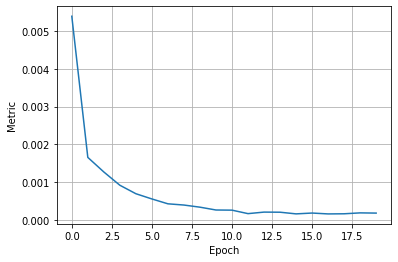

In [305]:
#!g1.1
for n in range(TaskConfig.num_epochs):

    train_epoch(model, opt, train_loader,
                melspec_train, config.device)

    au_fa_fr = validation(model, val_loader,
                          melspec_val, config.device)
    history['val_metric'].append(au_fa_fr)

    clear_output()
    plt.plot(history['val_metric'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

    print('END OF EPOCH', n)

In [307]:
#!g1.1
torch.save(model.state_dict(), './model_weights/main_model_20epochs.pth')

# Streaming example 

In [1210]:
#!g1.1
stream_loader = DataLoader(val_set, batch_size=100,
                        shuffle=False, collate_fn=Collator(),
                        sampler=val_sampler,
                        num_workers=0, pin_memory=True)
streaming_samples = []
streaming_labels = []
# for i, (batch, labels) in tqdm(enumerate(val_loader)):
batch, labels = next(iter(stream_loader))#batch, labels
for audio, label in zip(batch, labels):
    if len(streaming_samples) != 4 and label == torch.tensor(0):
            streaming_samples.append(audio)
            streaming_labels.append(label)
    elif len(streaming_samples) == 4 and label == torch.tensor(1):
        streaming_samples.append(audio)
        streaming_labels.append(label)
    if len(streaming_samples) == 9:
        break
streaming_samples, streaming_labels

([tensor([-0.0068, -0.0099, -0.0082,  ..., -0.0067, -0.0069, -0.0074]),
  tensor([ 0.0059,  0.0066,  0.0070,  ..., -0.0057, -0.0056, -0.0059]),
  tensor([ 2.7466e-04,  1.2207e-04,  1.5259e-04,  ...,  7.0190e-04,
          -9.1553e-05, -2.7466e-04]),
  tensor([-0.0017, -0.0037, -0.0065,  ...,  0.0042,  0.0034,  0.0023]),
  tensor([0.0000e+00, 9.1553e-05, 1.5259e-04,  ..., 1.2207e-04, 1.2207e-04,
          9.1553e-05]),
  tensor([-0.0078, -0.0086, -0.0096,  ..., -0.0093, -0.0092, -0.0091]),
  tensor([-0.0457, -0.0750, -0.0645,  ...,  0.0000,  0.0000,  0.0000]),
  tensor([0.0028, 0.0046, 0.0057,  ..., 0.0067, 0.0061, 0.0052]),
  tensor([0.0403, 0.0410, 0.0411,  ..., 0.0416, 0.0411, 0.0405])],
 [tensor(0),
  tensor(0),
  tensor(0),
  tensor(0),
  tensor(1),
  tensor(0),
  tensor(0),
  tensor(0),
  tensor(0)])

In [1249]:
#!g1.1
config = TaskConfig()
test_model = CRNNStreaming(config).to(config.device)
test_model.load_state_dict(torch.load('./main_model.pth'))
test_model.streaming

False

In [1285]:
#!g1.1
from math import ceil
def check_streaming(streaming_samples, test_model, STEP_SIZE):
    test_model.streaming = True
    test_model.clean_buffers()
    streaming_test_batch = torch.cat(streaming_samples, dim=-1)
    streaming_test_batch = streaming_test_batch.to(config.device)
    batch = melspec_val(streaming_test_batch).unsqueeze(dim=0)
    print('batch.shape', batch.shape, 'streaming_samples[0].shape', streaming_samples[0].shape)
    outs = []
    for i in range(0, batch.shape[-1] - 1, STEP_SIZE):
        new_batch = batch[:, :, i:i+STEP_SIZE]
        curr_batch = test_model(new_batch)
        if curr_batch is not None:
            outs.append(curr_batch)
    probs_list = []
    for out in outs:
        probs = F.softmax(out, dim=-1)
        probs_list.append(probs)
    probs1 = [p[:, 1] for p in probs_list]
    plot_probs = torch.stack(probs1).permute(1, 0)
    print("len of ", plot_probs.shape[1])
    plot_probs = plot_probs.reshape((plot_probs.shape[1],)).cpu().detach()
    plt.plot(plot_probs.numpy(), color='royalblue')
    n_frames_each_audio = ceil(plot_probs.shape[0] / 9)
    lborder_of_5th_fr, rborder_of_5th_fr = n_frames_each_audio * 4, n_frames_each_audio * 5 
    plt.vlines([lborder_of_5th_fr, rborder_of_5th_fr], ymin=0, ymax = 1, color='deeppink', linestyles='dashed')
    plt.ylabel('Probabilities of keyword')
    plt.xlabel(f'frames ({n_frames_each_audio}fr each audio)')
    plt.grid()
    plt.show()

Frame step_size is lower than kernel size
batch.shape torch.Size([1, 40, 901]) streaming_samples[0].shape torch.Size([16000])
len of  89


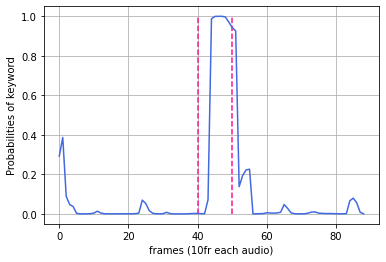

In [1286]:
#!g1.1
print("Frame step_size is lower than kernel size")
check_streaming(streaming_samples, test_model, 10)

batch.shape torch.Size([1, 40, 901]) streaming_samples[0].shape torch.Size([16000])
len of  45


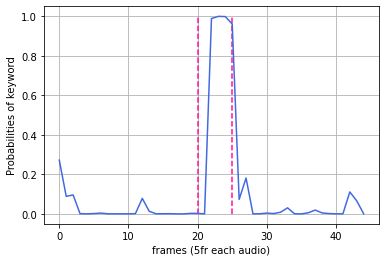

In [1287]:
#!g1.1
check_streaming(streaming_samples, test_model, 20)

batch.shape torch.Size([1, 40, 901]) streaming_samples[0].shape torch.Size([16000])
len of  45


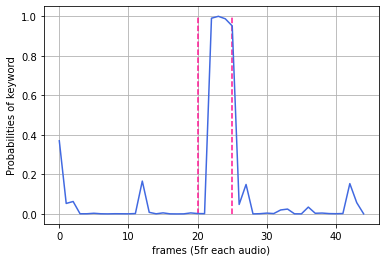

In [1289]:
#!g1.1
config = TaskConfig(max_window_length=20)
test_model = CRNNStreaming(config).to(config.device)
test_model.load_state_dict(torch.load('./main_model.pth'))
test_model.streaming
check_streaming(streaming_samples, test_model, 20)

# Distillation

In [480]:
#!g1.1
config = TaskConfig()
teacher = CRNN(config)
teacher.load_state_dict(torch.load('./model_weights/main_model.pth'))
teacher = teacher.to(config.device)

print("Teacher", model)


student_config = TaskConfig(
    cnn_out_channels = 8,
    kernel_size = (5, 20),
    stride = (2, 8),
    hidden_size = 40,
    gru_num_layers = 2,
    bidirectional = False)
print("student_config", student_config)
model = CRNN(student_config).to(student_config.device)
print("model", model)

opt = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)
# scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=len(train_loader), gamma=0.9998)
scheduler = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr=0.0008, steps_per_epoch=len(train_loader), epochs=30)

RUN_NAME = 'distilled-student-model_kernel-5-20_stride-2-8_hidden-size-40'

wandb.init(project='kws_hw', name=RUN_NAME)
estimation_model = CRNN(student_config)
print(estimate_model_complexity(estimation_model))

Teacher CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 40, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=40, out_features=40, bias=True)
      (1): Tanh()
      (2): Linear(in_features=40, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=40, out_features=2, bias=True)
)
student_config TaskConfig(keyword='sheila', batch_size=128, learning_rate=0.0003, weight_decay=1e-05, num_epochs=10, n_mels=40, cnn_out_channels=8, kernel_size=(5, 20), stride=(2, 8), hidden_size=40, gru_num_layers=2, bidirectional=False, num_classes=2, sample_rate=16000, max_window_length=30, device=device(type='cuda', index=0))
model CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 40, num_layers=2, batch_first=True, 

macs,▁
params,▁
size in megabytes,▁
time_on_10_frames,▁
time_on_one_frame,▁
macs,391312.0
params,34731.0
size in megabytes,0.13249
time_on_10_frames,0.06155
time_on_one_frame,0.01006


In [ ]:
#!g1.1
for n in range(40):

    train_epoch_distillation(teacher, model, opt,
                             train_loader, melspec_train,
                             config.device, temp=1.0, alpha=0.5, scheduler=scheduler)

    au_fa_fr = validation(model, val_loader,
                          melspec_val, config.device)
    history['val_metric'].append(au_fa_fr)
    wandb.log({'val_metric': au_fa_fr})

    clear_output()
    plt.plot(history['val_metric'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

    print('END OF EPOCH', n)
    if n % 5 == 0 and n > 10:
        torch.save(model.state_dict(), f'./model_weights/{RUN_NAME}_{n + 1}epochs.pth')

In [ ]:
#!g1.1


In [ ]:
#!g1.1


In [ ]:
config = TaskConfig(
    cnn_out_channels = 8,
    kernel_size = (5, 20),
    stride = (2, 8),
    hidden_size = 40,
    gru_num_layers = 2,
    bidirectional = False)
teacher = CRNN(config)
teacher.load_state_dict(torch.load('./model_weights/distilled_model.pth'))
teacher = teacher.to(config.device)

print("Teacher", teacher)


student_config = TaskConfig(
    cnn_out_channels = 2,
    kernel_size = (5, 20),
    stride = (2, 6),
    hidden_size = 16,
    gru_num_layers = 1,
    bidirectional = False)
print("student_config", student_config)
model = CRNN(student_config).to(student_config.device)
print("model", model)

opt = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)
# scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=len(train_loader), gamma=0.9998)
scheduler = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr=0.0009, steps_per_epoch=len(train_loader), epochs=80)

RUN_NAME = 'distilled-student-model_kernel-5-20_stride-2-6_hidden-size-16_grunum-1_cnnout-2'

wandb.init(project='kws_hw', name=RUN_NAME)
estimation_model = CRNN(student_config)
print(estimate_model_complexity(estimation_model))

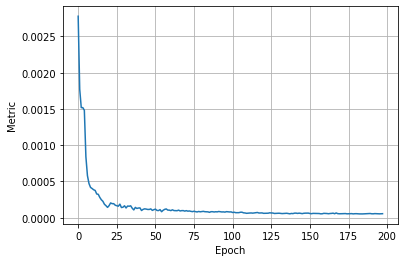

END OF EPOCH 149


In [1161]:
#!g1.1
opt = torch.optim.Adam(
    model.parameters(),
    lr=1e-4,
    weight_decay=config.weight_decay
)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=len(train_loader), gamma=0.998)
for n in range(200):

    train_epoch_distillation(teacher, model, opt,
                             train_loader, melspec_train,
                             config.device, temp=5.0, alpha=0.7, scheduler=scheduler)

    au_fa_fr = validation(model, val_loader,
                          melspec_val, config.device)
    history['val_metric'].append(au_fa_fr)
    wandb.log({'val_smetric': au_fa_fr})

    clear_output()
    plt.plot(history['val_metric'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

    print('END OF EPOCH', n)
    if au_fa_fr < 5.3e-5:
        torch.save(model.state_dict(), f'./model_weights/{RUN_NAME}_{n + 1}epochs.pth')
    if (n - 1) % 5 == 0 and n > 8:
        torch.save(model.state_dict(), f'./model_weights/{RUN_NAME}_{n + 1}epochs.pth')

In [ ]:
#!g1.1
